# Deep Learning

## Assignment 3

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
import os
data_root = 'E:/MYGIT/DataSources/notMNIST'
pickle_file = os.path.join(data_root, 'notMNIST_remove_oevrlap.pickle')
pickle_file_1 = os.path.join(data_root, 'notMNIST.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del(save)  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8984, 28, 28) (8984,)
Test set (8719, 28, 28) (8719,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (8984, 784) (8984, 10)
Test set (8719, 784) (8719, 10)


In [4]:
np.argmax??

In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Logistic model add L2

___

In [11]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))##随机梯度参数设置不同之处
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))##随机梯度参数设置不同之处
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)##L2参数设置

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                          (labels=tf_train_labels, logits=logits))beta_regul*tf.nn.l2_loss(weights)
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [13]:
num_steps = 3001
##3001*128 总共的训练数据   ## 之前是801*10000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        ##分母减去batch_size是防止当batch_size不能被训练数据量整除时，offset:(offset + batch_size)超出数组界限
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 22.505033
Minibatch accuracy: 10.2%
Validation accuracy: 10.2%
Minibatch loss at step 500: 2.375235
Minibatch accuracy: 79.7%
Validation accuracy: 74.9%
Minibatch loss at step 1000: 1.801144
Minibatch accuracy: 78.9%
Validation accuracy: 76.9%
Minibatch loss at step 1500: 1.527068
Minibatch accuracy: 76.6%
Validation accuracy: 78.7%
Minibatch loss at step 2000: 1.063528
Minibatch accuracy: 78.9%
Validation accuracy: 78.0%
Minibatch loss at step 2500: 0.587298
Minibatch accuracy: 90.6%
Validation accuracy: 80.3%
Minibatch loss at step 3000: 0.811859
Minibatch accuracy: 80.5%
Validation accuracy: 80.8%
Test accuracy: 87.6%


In [15]:
#测试L2正则系数不同时，ACC的表现
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        #f.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [17]:
import  matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test accuracy by regularization (logistic)')

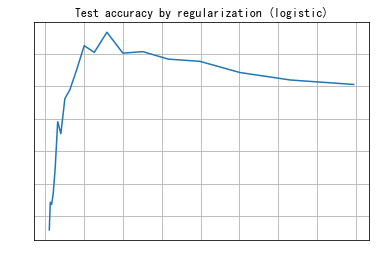

In [21]:
plt.plot(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')

neural network add L2

---

In [23]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32) ##addL2

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))##隐藏层1024个节点
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.##设置神经网络tf.nn.relu()里的参数相当于逻辑回归的函数logits
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))##add L2
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [24]:
num_steps = 3001
##3001*128 总共的训练数据   ## 之前是801*10000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 636.012085
Minibatch accuracy: 10.9%
Validation accuracy: 27.1%
Minibatch loss at step 500: 193.020981
Minibatch accuracy: 77.3%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 113.177940
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 1500: 68.721069
Minibatch accuracy: 81.2%
Validation accuracy: 81.9%
Minibatch loss at step 2000: 41.171753
Minibatch accuracy: 85.2%
Validation accuracy: 84.0%
Minibatch loss at step 2500: 25.151037
Minibatch accuracy: 90.6%
Validation accuracy: 85.1%
Minibatch loss at step 3000: 15.502783
Minibatch accuracy: 85.2%
Validation accuracy: 86.1%
Test accuracy: 92.2%


In [28]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Text(0.5, 1.0, 'Test accuracy by regularization (1-layer net)')

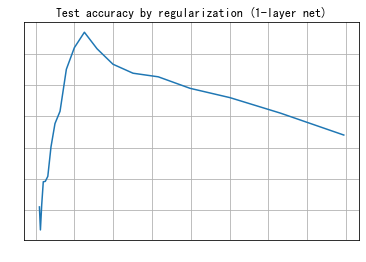

In [29]:
plt.plot(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')

## Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [30]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32) ##addL2

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))##隐藏层1024个节点
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.##设置神经网络tf.nn.relu()里的参数相当于逻辑回归的函数logits
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
    #+beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))##add L2
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [31]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        ##这里把相当于固定很小一部分的训练数据，然后一直训练这部分数据，所以可得到过拟合现象
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 333.795166
Minibatch accuracy: 14.1%
Validation accuracy: 23.8%
Minibatch loss at step 10: 24.655172
Minibatch accuracy: 92.2%
Validation accuracy: 71.5%
Minibatch loss at step 20: 6.236622
Minibatch accuracy: 98.4%
Validation accuracy: 72.5%
Minibatch loss at step 30: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 50: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 70: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 90: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [32]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32) ##addL2

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))##隐藏层1024个节点
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.##设置神经网络tf.nn.relu()里的参数相当于逻辑回归的函数logits
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5) #add drop
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
    #+beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))##add L2
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        ##这里把相当于固定很小一部分的训练数据，然后一直训练这部分数据，所以可得到过拟合现象
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 518.917480
Minibatch accuracy: 10.2%
Validation accuracy: 29.7%
Minibatch loss at step 10: 61.548069
Minibatch accuracy: 82.8%
Validation accuracy: 71.0%
Minibatch loss at step 20: 21.000814
Minibatch accuracy: 90.6%
Validation accuracy: 70.1%
Minibatch loss at step 30: 4.510040
Minibatch accuracy: 95.3%
Validation accuracy: 73.8%
Minibatch loss at step 40: 1.190803
Minibatch accuracy: 97.7%
Validation accuracy: 73.4%
Minibatch loss at step 50: 2.163004
Minibatch accuracy: 98.4%
Validation accuracy: 74.7%
Minibatch loss at step 60: 0.359124
Minibatch accuracy: 99.2%
Validation accuracy: 74.2%
Minibatch loss at step 70: 1.784384
Minibatch accuracy: 98.4%
Validation accuracy: 73.4%
Minibatch loss at step 80: 1.012117
Minibatch accuracy: 99.2%
Validation accuracy: 74.2%
Minibatch loss at step 90: 3.897972
Minibatch accuracy: 98.4%
Validation accuracy: 75.0%
Minibatch loss at step 100: 0.481134
Minibatch accuracy: 98.4%
Validation accuracy: 73.9%
Test 

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    tf.train.exponential_decay(
    learning_rate,
    global_step,
    decay_steps,
    decay_rate,
    staircase=False,
    name=None,)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [37]:
tf.train.exponential_decay??

In [36]:
tf.truncated_normal??

In [38]:
#2层神经网络
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    #第一层输入节点是28*28级原始数据的维度大小，本层节点是个数是num_hidden_nodes1
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
    #第二层的输入节点是第一层节点个数，本层节点个数是num_hidden_nodes2,stddev是指定生成数据的标准差
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    #最后一层的输入节点个数是第二层节点个数，本层节点个数是要分类的类别个数。
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [40]:
num_steps = 9001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.200811
Minibatch accuracy: 12.5%
Validation accuracy: 40.3%
Minibatch loss at step 500: 0.949447
Minibatch accuracy: 89.8%
Validation accuracy: 85.3%
Minibatch loss at step 1000: 0.794478
Minibatch accuracy: 87.5%
Validation accuracy: 86.5%
Minibatch loss at step 1500: 0.860234
Minibatch accuracy: 81.2%
Validation accuracy: 87.5%
Minibatch loss at step 2000: 0.687163
Minibatch accuracy: 86.7%
Validation accuracy: 87.7%
Minibatch loss at step 2500: 0.465837
Minibatch accuracy: 93.0%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.611498
Minibatch accuracy: 87.5%
Validation accuracy: 88.4%
Minibatch loss at step 3500: 0.473561
Minibatch accuracy: 91.4%
Validation accuracy: 89.1%
Minibatch loss at step 4000: 0.445982
Minibatch accuracy: 90.6%
Validation accuracy: 89.2%
Minibatch loss at step 4500: 0.421937
Minibatch accuracy: 93.0%
Validation accuracy: 89.2%
Minibatch loss at step 5000: 0.509907
Minibatch accuracy: 89.1%
Validation accurac

In [44]:
#三层神经网络
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, 
                                                num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+ tf.nn.l2_loss(weights4))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [45]:
num_steps = 18001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.511766
Minibatch accuracy: 10.2%
Validation accuracy: 23.6%
Minibatch loss at step 500: 1.095654
Minibatch accuracy: 88.3%
Validation accuracy: 85.4%
Minibatch loss at step 1000: 0.874152
Minibatch accuracy: 89.1%
Validation accuracy: 86.0%
Minibatch loss at step 1500: 0.890295
Minibatch accuracy: 81.2%
Validation accuracy: 86.8%
Minibatch loss at step 2000: 0.678811
Minibatch accuracy: 85.9%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 0.467644
Minibatch accuracy: 92.2%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 0.599171
Minibatch accuracy: 86.7%
Validation accuracy: 87.0%
Minibatch loss at step 3500: 0.480820
Minibatch accuracy: 90.6%
Validation accuracy: 88.3%
Minibatch loss at step 4000: 0.464675
Minibatch accuracy: 89.1%
Validation accuracy: 88.1%
Minibatch loss at step 4500: 0.366282
Minibatch accuracy: 93.0%
Validation accuracy: 88.8%
Minibatch loss at step 5000: 0.516457
Minibatch accuracy: 86.7%
Validation accurac

In [46]:
###3层神经网络+随机失活(dropout)
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # Variables.
    weights1 = tf.Variable( tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, 
                                                num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(lay2_train, 0.5)
    lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(lay3_train, 0.5)
    logits = tf.matmul(drop3, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) #+ \
     # beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+tf.nn.l2_loss(weights4))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [47]:
num_steps = 20001
step_save = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        step_save.append(global_step)
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.742796
Minibatch accuracy: 9.4%
Validation accuracy: 19.2%
Minibatch loss at step 500: 0.517210
Minibatch accuracy: 85.2%
Validation accuracy: 83.2%
Minibatch loss at step 1000: 0.614306
Minibatch accuracy: 82.0%
Validation accuracy: 84.8%
Minibatch loss at step 1500: 0.636285
Minibatch accuracy: 80.5%
Validation accuracy: 85.3%
Minibatch loss at step 2000: 0.584990
Minibatch accuracy: 82.8%
Validation accuracy: 85.8%
Minibatch loss at step 2500: 0.401859
Minibatch accuracy: 87.5%
Validation accuracy: 85.4%
Minibatch loss at step 3000: 0.589148
Minibatch accuracy: 80.5%
Validation accuracy: 86.0%
Minibatch loss at step 3500: 0.453759
Minibatch accuracy: 86.7%
Validation accuracy: 86.9%
Minibatch loss at step 4000: 0.444367
Minibatch accuracy: 85.2%
Validation accuracy: 86.9%
Minibatch loss at step 4500: 0.419620
Minibatch accuracy: 89.8%
Validation accuracy: 87.8%
Minibatch loss at step 5000: 0.508793
Minibatch accuracy: 82.8%
Validation accuracy